In [67]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
import math

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

In [2]:
def get_model(config):
    if config['mode'] == 'photo':
        model = Informer(config)
    elif config['mode'] == 'spectra':
        model = GalSpecNet(config)
    elif config['mode'] == 'meta':
        model = MetaModel(config)
    else:
        model = AstroModel(config)

    return model

def get_embs(dataloader):
    all_p_emb, all_s_emb, all_m_emb = [], [], []
    all_labels = []
    
    for photometry, photometry_mask, spectra, metadata, labels in tqdm(dataloader):
        photometry, photometry_mask = photometry.to(device), photometry_mask.to(device)
        spectra, metadata = spectra.to(device), metadata.to(device)
    
        with torch.no_grad():
            p_emb, s_emb, m_emb = model.get_embeddings(photometry, photometry_mask, spectra, metadata)
    
            all_p_emb.append(p_emb.cpu())
            all_s_emb.append(s_emb.cpu())
            all_m_emb.append(m_emb.cpu())
            all_labels.append(labels)
    
    all_p_emb = torch.vstack(all_p_emb)
    all_s_emb = torch.vstack(all_s_emb)
    all_m_emb = torch.vstack(all_m_emb)
    all_labels = torch.hstack(all_labels)

    return all_p_emb, all_s_emb, all_m_emb, all_labels

def get_centers(p_emb, s_emb, m_emb, train_labels):
    p_centers, s_centers, m_centers, all_centers = [], [], [], []

    for i in range(10):
        ind = train_labels == i
    
        p_center = p_emb[ind].mean(axis=0)
        p_center = p_center / p_center.norm()
        p_centers.append(p_center)
    
        s_center = s_emb[ind].mean(axis=0)
        s_center = s_center / s_center.norm()
        s_centers.append(s_center)
    
        m_center = m_emb[ind].mean(axis=0)
        m_center = m_center / m_center.norm()
        m_centers.append(m_center)

        all_emb = (p_emb + s_emb + m_emb) / 3
        all_center = all_emb[ind].mean(axis=0)
        all_center = all_center / all_center.norm()
        all_centers.append(all_center)
    
    p_centers = torch.stack(p_centers)
    s_centers = torch.stack(s_centers)
    m_centers = torch.stack(m_centers)
    all_centers = torch.stack(all_centers)

    return p_centers, s_centers, m_centers, all_centers

In [3]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)
config = run.config
config['use_wandb'] = False

model = get_model(config)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

weights_path = os.path.join(config['weights_path'] + '-' + run_id.split('/')[-1], f'weights-best.pth')
model.load_state_dict(torch.load(weights_path, weights_only=False))

<All keys matched successfully>

In [49]:
train_dataset = PSMDataset(config, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = PSMDataset(config, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

train_p_emb, train_s_emb, train_m_emb, train_labels = get_embs(train_dataloader)
test_p_emb, test_s_emb, test_m_emb, test_labels = get_embs(test_dataloader)

p_centers, s_centers, m_centers, all_centers = get_centers(train_p_emb, train_s_emb, train_m_emb, train_labels)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.62s/it]


# Photometry

In [144]:
distances_p = torch.zeros(test_labels.shape)

for i in range(10):
    ind = test_labels == i
    dist = 1 - test_p_emb[ind] @ p_centers[i]
    distances_p[ind] = dist

(array([ 44., 259., 499., 537., 432., 255., 131.,  45.,  17.,   6.]),
 array([0.03508306, 0.13174348, 0.2284039 , 0.32506433, 0.42172474,
        0.51838517, 0.61504561, 0.71170604, 0.80836642, 0.90502685,
        1.00168729]),
 <BarContainer object of 10 artists>)

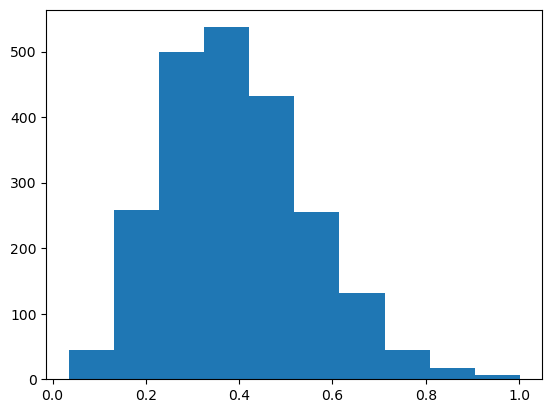

In [145]:
plt.hist(distances_p)

In [151]:
topk_values_p, topk_indices_p = torch.topk(distances_p, k=20, largest=True)
pred_labels_p = torch.argmax(test_p_emb[topk_indices_p] @ p_centers.T, axis=1)
true_labels_p = test_labels[topk_indices_p]

topk_values_p, topk_indices_p, pred_labels_p, true_labels_p

(tensor([1.0017, 0.9537, 0.9491, 0.9470, 0.9363, 0.9205, 0.9048, 0.9047, 0.8870,
         0.8835, 0.8615, 0.8581, 0.8566, 0.8554, 0.8509, 0.8351, 0.8305, 0.8282,
         0.8272, 0.8249]),
 tensor([ 276,  650, 1473,  207,  905,  131,  672, 1516,  859,  586,  113, 1281,
          792,  434, 1628, 1012, 2012, 1983, 1794, 1163]),
 tensor([8, 3, 2, 2, 2, 6, 8, 3, 5, 2, 2, 3, 8, 3, 3, 3, 7, 5, 2, 3]),
 tensor([1, 2, 3, 3, 3, 8, 3, 8, 3, 1, 8, 1, 2, 1, 1, 2, 3, 3, 3, 2]))

# ADD PERIOD

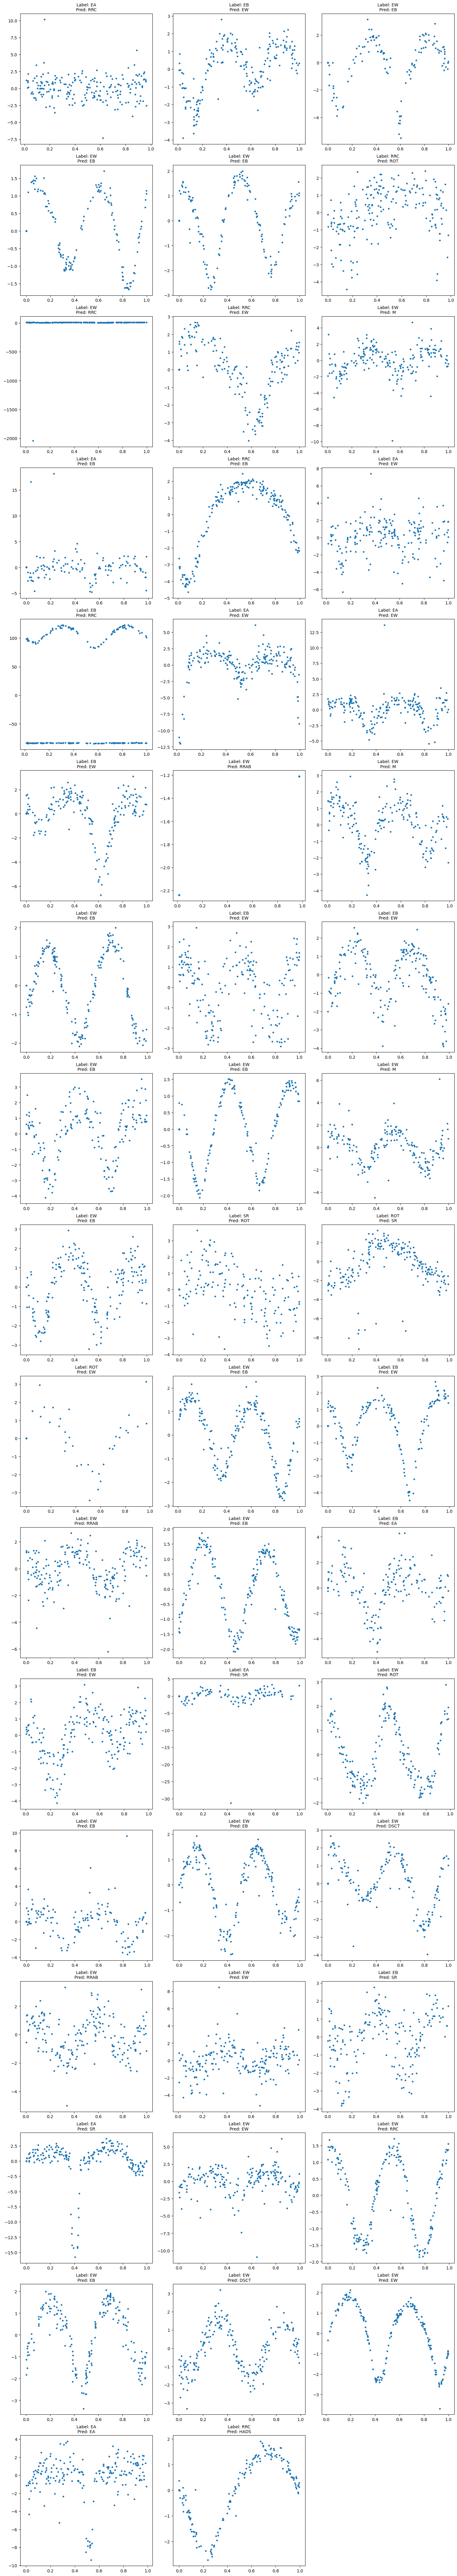

In [165]:
test_dataset.phased = True

# Define number of rows and columns (3 columns)
num_cols = 3
num_rows = math.ceil(len(topk_indices_p) / num_cols)

# Create subplots with the calculated number of rows and 3 columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)

# Flatten the axs array if there are multiple rows
axs = axs.flatten()

# Loop over top-k indices to plot each object in its own subplot
for i, idx in enumerate(topk_indices_p):
    # Fetch the photometry data for the object from the test dataset
    photometry, photometry_mask, spectra, metadata, label = test_dataset[idx.item()]
    
    # Plot the photometry data for this object in its respective subplot
    axs[i].plot(photometry[:, 0], photometry[:, 1], '.')
    
    # Add title and labels to each subplot
    axs[i].set_title(f'Label: {test_dataset.id2target[true_labels_p[i].item()]}\nPred: {test_dataset.id2target[pred_labels_p[i].item()]}', fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Display the plot
plt.show()

# Spectra

In [74]:
distances_s = torch.zeros(test_labels.shape)

for i in range(10):
    ind = test_labels == i
    dist = 1 - test_s_emb[ind] @ s_centers[i]
    distances_s[ind] = dist

(array([111., 315., 552., 517., 361., 189.,  97.,  55.,  26.,   2.]),
 array([0.04304665, 0.15376225, 0.26447785, 0.37519345, 0.48590904,
        0.59662461, 0.70734024, 0.81805587, 0.92877144, 1.039487  ,
        1.15020263]),
 <BarContainer object of 10 artists>)

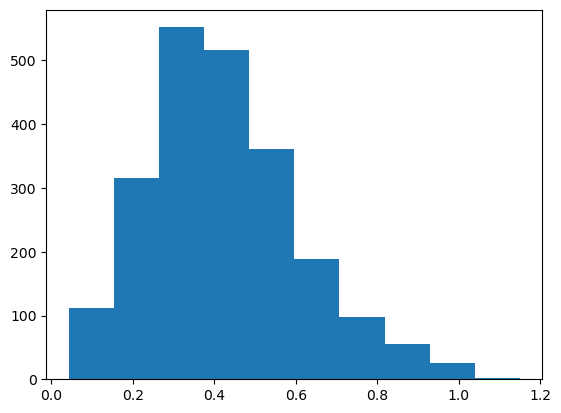

In [75]:
plt.hist(distances_s)

In [77]:
topk_values_s, topk_indices_s = torch.topk(distances_s, k=20, largest=True)
pred_labels_s = torch.argmax(test_s_emb[topk_indices_s] @ s_centers.T, axis=1)
true_labels_s = test_labels[topk_indices_s]

topk_values_s, topk_indices_s, pred_labels_s, true_labels_s

(tensor([1.1502, 1.0977, 1.0316, 1.0310, 1.0292, 1.0273, 1.0140, 1.0107, 1.0103,
         1.0024, 1.0017, 0.9997, 0.9907, 0.9835, 0.9640, 0.9613, 0.9525, 0.9519,
         0.9487, 0.9474]),
 tensor([ 113,  227, 1737, 1794, 1381,  509,  362,  504, 1163, 1676,    8, 1281,
          129,  713, 1218, 1012, 2204, 2165, 1878,  413]),
 tensor([2, 6, 0, 0, 3, 8, 8, 3, 3, 7, 0, 6, 7, 7, 0, 6, 0, 6, 6, 8]),
 tensor([8, 2, 3, 3, 7, 3, 1, 1, 2, 3, 7, 1, 4, 3, 3, 2, 3, 2, 1, 2]))

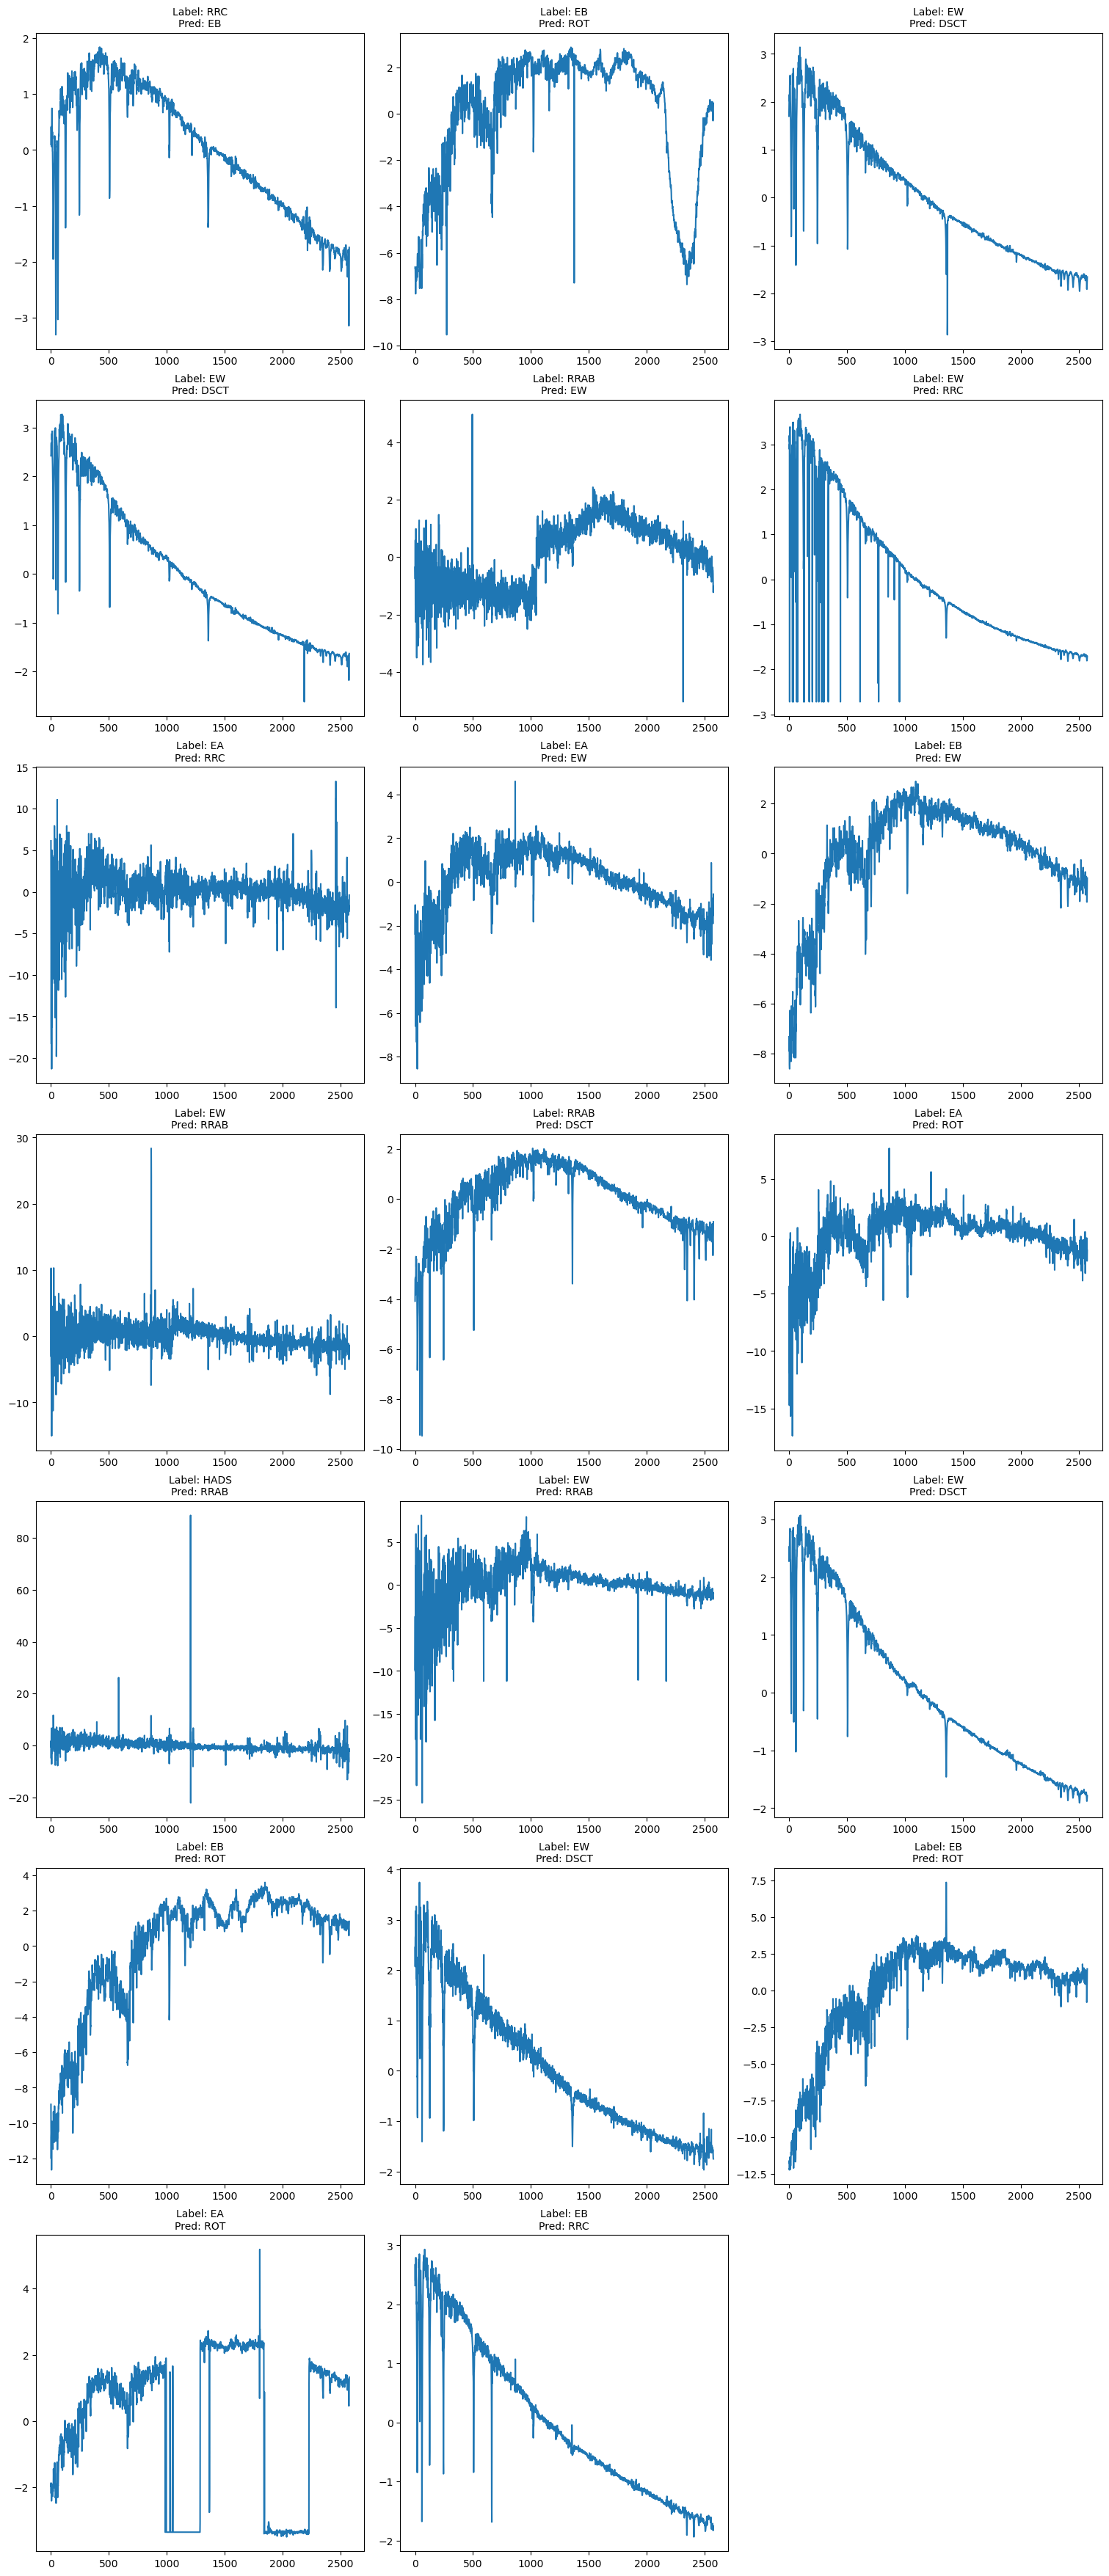

In [86]:
# Define number of rows and columns (3 columns)
num_cols = 3
num_rows = math.ceil(len(topk_indices_p) / num_cols)

# Create subplots with the calculated number of rows and 3 columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True)

# Flatten the axs array if there are multiple rows
axs = axs.flatten()

# Loop over top-k indices to plot each object in its own subplot
for i, idx in enumerate(topk_indices_s):
    # Fetch the photometry data for the object from the test dataset
    photometry, photometry_mask, spectra, metadata, label = test_dataset[idx.item()]
    
    # Plot the photometry data for this object in its respective subplot
    axs[i].plot(spectra[0, :])
    
    # Add title and labels to each subplot
    axs[i].set_title(f'Label: {test_dataset.id2target[true_labels_s[i].item()]}\nPred: {test_dataset.id2target[pred_labels_s[i].item()]}', fontsize=10)

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Display the plot
plt.show()

# Metadata

(array([ 43., 145., 392., 653., 534., 266., 116.,  47.,  24.,   5.]),
 array([0.04227471, 0.14085737, 0.23944004, 0.33802271, 0.43660536,
        0.53518802, 0.6337707 , 0.73235333, 0.83093601, 0.92951864,
        1.02810133]),
 <BarContainer object of 10 artists>)

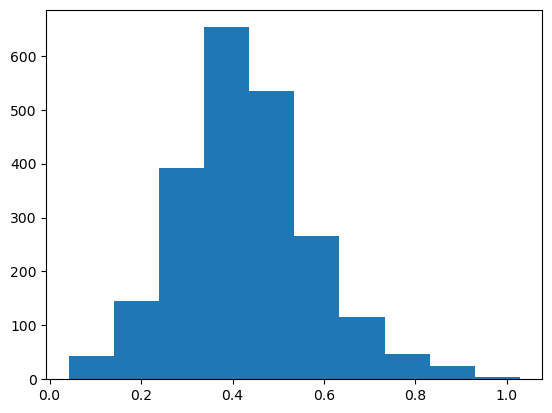

In [87]:
distances_m = torch.zeros(test_labels.shape)

for i in range(10):
    ind = test_labels == i
    dist = 1 - test_m_emb[ind] @ m_centers[i]
    distances_m[ind] = dist

plt.hist(distances_m)

In [88]:
topk_values_m, topk_indices_m = torch.topk(distances_m, k=20, largest=True)
pred_labels_m = torch.argmax(test_m_emb[topk_indices_m] @ m_centers.T, axis=1)
true_labels_m = test_labels[topk_indices_m]

topk_values_m, topk_indices_m, pred_labels_m, true_labels_m

(tensor([1.0281, 1.0053, 0.9616, 0.9407, 0.9396, 0.9237, 0.9197, 0.9157, 0.9133,
         0.9052, 0.9042, 0.9035, 0.9014, 0.8957, 0.8870, 0.8867, 0.8792, 0.8758,
         0.8733, 0.8575]),
 tensor([ 113,  276, 1012, 1149, 1163, 2204,  504,  586, 1317, 1281,  479, 1628,
         1465, 1937, 1794, 1625,  227, 1473,  207, 1436]),
 tensor([2, 3, 3, 1, 3, 0, 7, 7, 2, 7, 3, 3, 0, 6, 0, 3, 3, 0, 2, 3]),
 tensor([8, 1, 2, 2, 2, 3, 1, 1, 3, 1, 1, 1, 3, 2, 3, 1, 2, 3, 3, 2]))

In [89]:
topk_indices_p, topk_indices_s, topk_indices_m

(tensor([ 276,  650, 1473,  207,  905,  131,  672, 1516,  859,  586,  113, 1281,
          792,  434, 1628, 1012, 2012, 1983, 1794, 1163]),
 tensor([ 113,  227, 1737, 1794, 1381,  509,  362,  504, 1163, 1676,    8, 1281,
          129,  713, 1218, 1012, 2204, 2165, 1878,  413]),
 tensor([ 113,  276, 1012, 1149, 1163, 2204,  504,  586, 1317, 1281,  479, 1628,
         1465, 1937, 1794, 1625,  227, 1473,  207, 1436]))

In [100]:
ps = topk_indices_p[torch.isin(topk_indices_p, topk_indices_s)]
ps

tensor([ 113, 1281, 1012, 1794, 1163])

In [101]:
sm = topk_indices_s[torch.isin(topk_indices_s, topk_indices_m)]
sm

tensor([ 113,  227, 1794,  504, 1163, 1281, 1012, 2204])

In [102]:
mp = topk_indices_m[torch.isin(topk_indices_m, topk_indices_p)]
mp

tensor([ 113,  276, 1012, 1163,  586, 1281, 1628, 1794, 1473,  207])

In [106]:
w = ps[torch.isin(ps, sm)]
w

tensor([ 113, 1281, 1012, 1794, 1163])

In [108]:
pred_labels_p = torch.argmax(test_p_emb[w] @ p_centers.T, axis=1)
pred_labels_s = torch.argmax(test_s_emb[w] @ s_centers.T, axis=1)
pred_labels_m = torch.argmax(test_m_emb[w] @ m_centers.T, axis=1)
true_labels = test_labels[w]

pred_labels_p, pred_labels_s, pred_labels_m, true_labels

(tensor([2, 3, 3, 2, 3]),
 tensor([2, 6, 6, 0, 3]),
 tensor([2, 7, 3, 0, 3]),
 tensor([8, 1, 2, 3, 2]))

# Plot misclassifications on UMAP

In [116]:
class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

palette = sns.color_palette("tab20", len(id2target))
marker_size = 12

In [136]:
def plot_one_embs_outliers(embeddings, targets, outliers=None):
    plt.figure(figsize=(10, 8))
    
    for class_name in sorted_classes:
        class_id = target2id[class_name]
        class_mask = targets == class_id
        plt.scatter(embeddings[class_mask, 0], embeddings[class_mask, 1], 
                    color=palette[class_id], label=class_name, alpha=0.7, s=marker_size)

    if outliers is not None:
        plt.scatter(embeddings[outliers, 0], embeddings[outliers, 1], 
                    facecolor='none', edgecolor='black', s=marker_size, label='Outliers')

    handles_colors = [mlines.Line2D([], [], color=palette[target2id[class_name]], marker='o', linestyle='None', markersize=8, 
                      label=class_name) for class_name in sorted_classes]
    plt.legend(handles=handles_colors, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=10, title="Classes")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

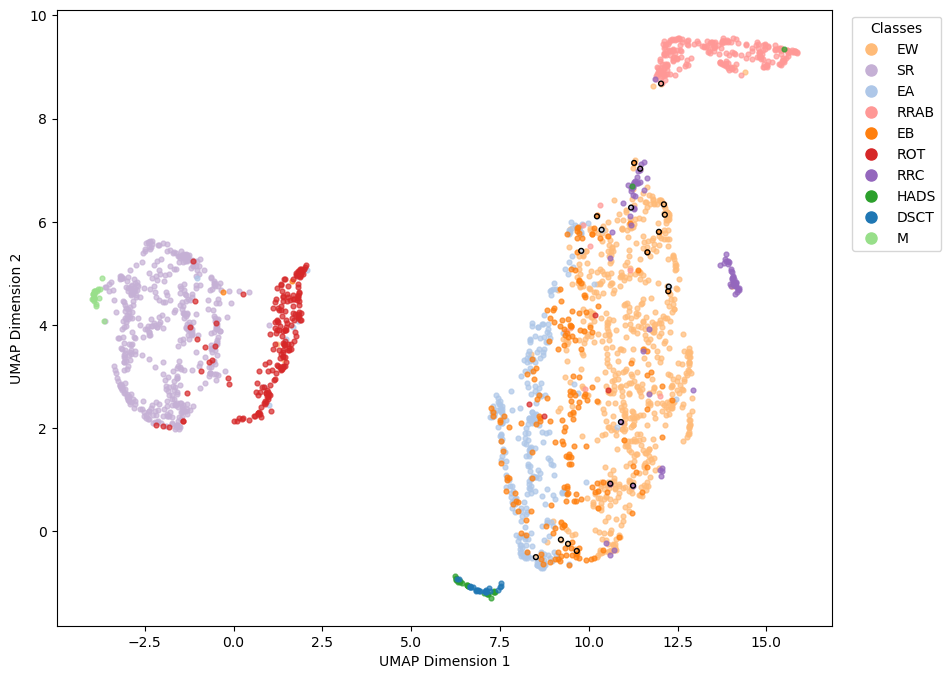

In [138]:
umap_model = umap.UMAP(n_neighbors=22, n_components=2, metric='cosine', n_jobs=1, random_state=42)
p_emb_umap = umap_model.fit_transform(test_p_emb)
plot_one_embs_outliers(p_emb_umap, test_labels, topk_indices_p)

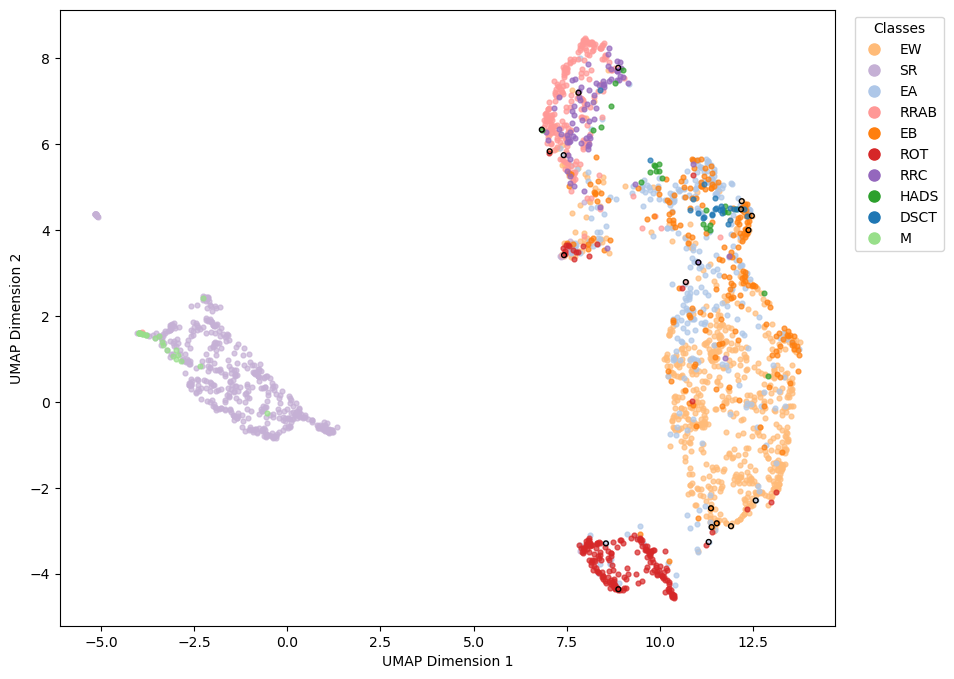

In [139]:
umap_model = umap.UMAP(n_neighbors=22, n_components=2, metric='cosine', n_jobs=1, random_state=42)
s_emb_umap = umap_model.fit_transform(test_s_emb)
plot_one_embs_outliers(s_emb_umap, test_labels, topk_indices_s)

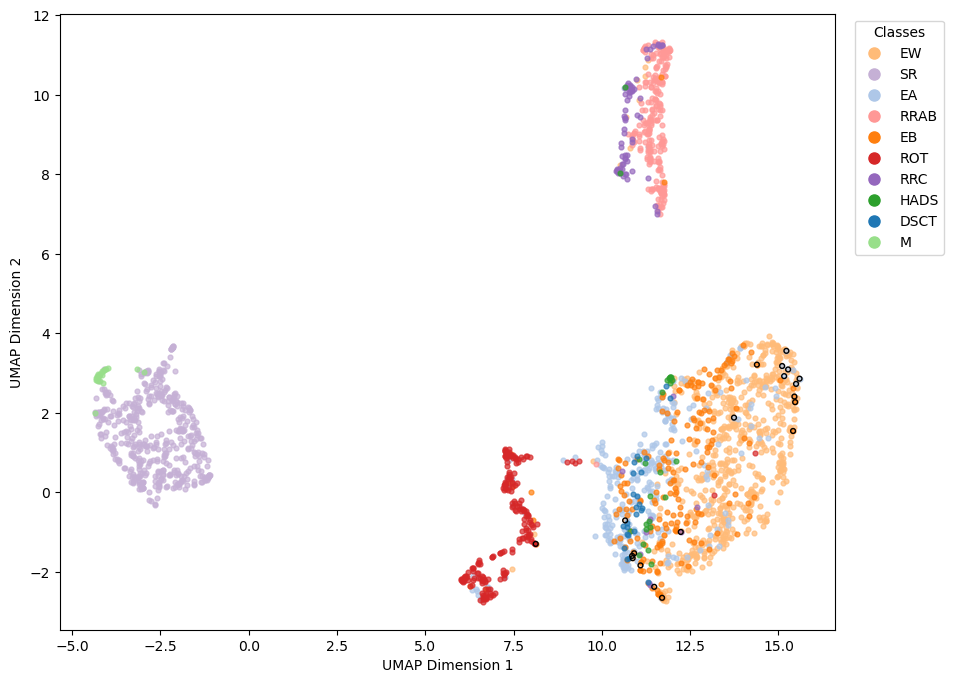

In [140]:
umap_model = umap.UMAP(n_neighbors=22, n_components=2, metric='cosine', n_jobs=1, random_state=42)
m_emb_umap = umap_model.fit_transform(test_m_emb)
plot_one_embs_outliers(m_emb_umap, test_labels, topk_indices_m)

# k = 50

In [153]:
topk_values_p, topk_indices_p = torch.topk(distances_p, k=50, largest=True)
pred_labels_p = torch.argmax(test_p_emb[topk_indices_p] @ p_centers.T, axis=1)
true_labels_p = test_labels[topk_indices_p]

topk_values_p, topk_indices_p, pred_labels_p, true_labels_p

(tensor([1.0017, 0.9537, 0.9491, 0.9470, 0.9363, 0.9205, 0.9048, 0.9047, 0.8870,
         0.8835, 0.8615, 0.8581, 0.8566, 0.8554, 0.8509, 0.8351, 0.8305, 0.8282,
         0.8272, 0.8249, 0.8147, 0.8118, 0.8089, 0.8024, 0.7972, 0.7942, 0.7937,
         0.7910, 0.7900, 0.7811, 0.7759, 0.7759, 0.7737, 0.7712, 0.7678, 0.7674,
         0.7654, 0.7642, 0.7546, 0.7491, 0.7486, 0.7475, 0.7416, 0.7410, 0.7407,
         0.7397, 0.7395, 0.7362, 0.7347, 0.7324]),
 tensor([ 276,  650, 1473,  207,  905,  131,  672, 1516,  859,  586,  113, 1281,
          792,  434, 1628, 1012, 2012, 1983, 1794, 1163, 1149, 1317, 1373, 2029,
          123,    6, 1229, 1593, 1737, 1897,  595, 1752, 2112, 2143, 1412,  117,
         1973,  766, 1465, 1747,  530, 1383,  192,  713,  797, 2204,  350,  962,
          426,  132]),
 tensor([8, 3, 2, 2, 2, 6, 8, 3, 5, 2, 2, 3, 8, 3, 3, 3, 7, 5, 2, 3, 3, 2, 2, 5,
         2, 6, 9, 3, 2, 3, 7, 2, 1, 3, 9, 6, 2, 2, 0, 7, 3, 9, 9, 3, 8, 2, 0, 3,
         1, 4]),
 tensor([1, 2, 3, 

In [156]:
topk_indices_p[pred_labels_p == true_labels_p]

tensor([530, 713, 962, 426])

In [163]:
test_p_emb[530] @ p_centers.T, test_p_emb[713] @ p_centers.T, test_p_emb[962] @ p_centers.T, test_p_emb[426] @ p_centers.T

(tensor([-0.0288, -0.1070, -0.0864,  0.2514,  0.0336,  0.1836,  0.0928,  0.2462,
          0.2381,  0.0849]),
 tensor([-0.0113, -0.1013, -0.1328,  0.2590,  0.0119,  0.1430,  0.1288,  0.2367,
          0.2028,  0.1058]),
 tensor([ 0.0533, -0.1010,  0.0592,  0.2638,  0.0492,  0.0029,  0.1566,  0.0808,
          0.0815, -0.0585]),
 tensor([ 0.0960,  0.2653,  0.1154, -0.0511, -0.0638, -0.0999,  0.2102,  0.0004,
         -0.0227,  0.0953]))

In [164]:
test_labels[topk_indices_p[pred_labels_p == true_labels_p]]

tensor([3, 3, 3, 1])